In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
import numpy as n
import os
import json
import re

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
path = '/content/drive/My Drive/Data/gtdnorm.csv'
df = pd.read_csv(path)

In [ ]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
for i in df.iloc[0]:
  if not (i >= 0 and i <= 1):
    print(i)

10.0


In [ ]:
from torch.utils.data import Dataset

In [ ]:
df = df.iloc[0:93500]

In [ ]:
class GTD(Dataset):
    def __init__(self, df):

        self.x = torch.tensor(df[[i for i in df.columns if i != 'target']].values, dtype=torch.float32)
        self.y = torch.tensor(df.target.values, dtype=torch.long)
        self.n_samples = len(df)

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.n_samples

In [ ]:
gtd_ds = GTD(df)

In [ ]:
len(gtd_ds)

93500

In [ ]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(df))
test_size = len(df) - train_size
train_dataset, test_dataset = random_split(gtd_ds, [train_size, test_size])

In [ ]:
batch_size = 100
num_iters = 3000
input_dim = df.shape[1]-1 # num_features = 43
num_hidden = 100 # num of hidden nodes
output_dim = len(df.target.unique()) #11

learning_rate = 0.001  # More power so we can learn faster! previously it was 0.001

In [ ]:
num_epochs = 25 #num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
for i in train_loader:
  print(i)
  break

[tensor([[0.3121, 0.2763, 0.4823,  ..., 0.0000, 0.0000, 0.0000],
        [0.5730, 0.6009, 0.6592,  ..., 0.0000, 0.0000, 0.0000],
        [0.4502, 0.2852, 0.6069,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.6724, 0.6234, 0.6427,  ..., 0.0000, 1.0000, 1.0000],
        [0.5072, 0.5680, 0.6358,  ..., 0.9000, 0.0000, 0.9000],
        [0.5904, 0.5616, 0.5978,  ..., 0.0000, 0.0000, 0.0000]]), tensor([ 0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0, 10,
         1,  0,  0,  0,  0, 10,  0,  0,  0,  0,  1,  8,  0, 10, 10,  0,  0,  0,
        10, 10,  1,  0,  0, 10, 10,  0, 10, 10, 10,  0,  9, 10,  0,  0, 10,  0,
         0,  2,  0, 10,  1,  2,  0,  0,  0,  1, 10,  3,  0,  3,  8,  1, 10, 10,
         0,  1, 10,  0,  0,  0, 10,  0,  2,  0,  0,  0,  0,  1,  7,  5,  0,  0,
         0, 10, 10, 10,  0, 10,  2,  0,  5,  0])]


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, _ = self.gru(x, (h0.detach()))

        # Index hidden state of last time step
        out = self.fc(self.relu(out[:, -1, :]))

        return out

# Define hyperparameters
input_size = input_dim  # Number of input features
hidden_size = 64  # Number of LSTM units
num_layers = 2  # Number of LSTM layers
output_size = 11  # Number of output classes

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
print(model)

LSTMModel(
  (gru): GRU(1579, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=11, bias=True)
  (relu): ReLU()
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 100

In [ ]:
iter = 0
for epoch in range(num_epochs):

  for i, (inputs, labels) in enumerate(train_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs.reshape(100, 1, input_dim))

      loss = criterion(outputs, labels)

      loss.backward()

      optimizer.step()

      iter += 1
      if iter % 500 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0

            for input, labels in test_loader:
                input = input.to(device)

                # Forward pass only to get logits/output
                outputs = model(input.reshape(100, 1, input_dim))

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = correct / total * 100
            print('Accuracy:', accuracy)
  print('Epoch [{}/{}] Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Accuracy: tensor(84.2620)
Epoch [1/100] Loss: 0.3958
Accuracy: tensor(92.1711)
Epoch [2/100] Loss: 0.1863
Accuracy: tensor(94.9251)
Accuracy: tensor(96.5989)
Epoch [3/100] Loss: 0.1173
Accuracy: tensor(97.3583)
Epoch [4/100] Loss: 0.0818


KeyboardInterrupt: ignored

In [ ]:
import numpy as np

In [ ]:
yp = np.array([])
yt = np.array([])

for input, labels in test_loader:

                input = input.to(device)

                # Forward pass only to get logits/output
                outputs = model(input.reshape(100, 1, input_dim))

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)


                yp = np.concatenate((yp, predicted.numpy()))
                yt = np.concatenate((yt, labels.numpy()))

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

print(yt.shape, yp.shape)
print(yt[:10])
print(yp[:10])


(18700,) (18700,)
[10. 10.  2.  1.  0. 10.  0. 10. 10. 10.]
[10. 10.  2.  1.  0. 10.  0. 10. 10. 10.]


In [ ]:
res = yt==yp
print(res.sum())

18210


In [ ]:
from sklearn import metrics

cm = metrics.confusion_matrix(yt, yp)

In [ ]:
cm

array([[9297,    1,    3,    0,    0,    0,    0,    6,    0,    0,   45],
       [   0, 1288,    0,    0,    0,    0,    0,    0,    0,    0,    4],
       [   0,    0,  992,    0,    0,    0,    0,    0,    0,    1,   12],
       [   0,    0,    1,  539,    0,    0,    0,    0,    0,    0,    2],
       [   0,    0,    0,    0,  356,    0,    0,    0,    0,    0,   10],
       [   0,    0,    0,    1,    0,  384,    0,    0,    0,    0,    3],
       [   0,    0,    0,    0,    0,    0,  375,    0,    0,    0,   21],
       [   7,    0,    0,    0,    0,    0,    0,  288,    0,    0,    6],
       [   0,    0,    0,    0,    0,    0,    0,    7,  193,    0,   14],
       [   0,    0,    6,    0,    0,    0,    0,    0,    0,  214,    3],
       [ 186,   23,   44,   26,    4,   19,    2,   12,    9,   12, 4284]])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<function matplotlib.pyplot.show(close=None, block=None)>

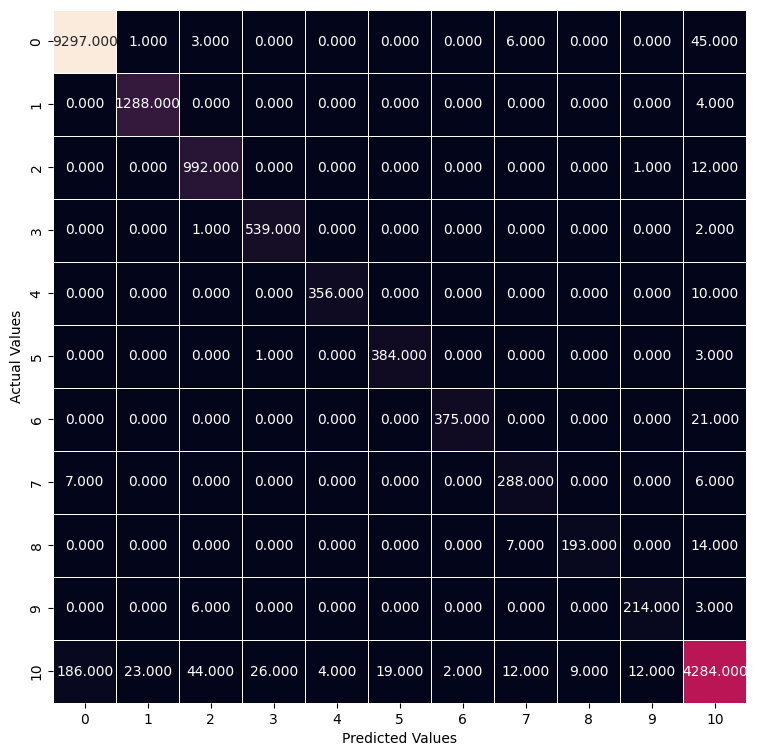

In [ ]:
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot = True, fmt = '0.3f', linewidth = 0.5, square = True, cbar = False)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show

In [ ]:
print(metrics.classification_report(yt, yp))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9352
         1.0       0.98      1.00      0.99      1292
         2.0       0.95      0.99      0.97      1005
         3.0       0.95      0.99      0.97       542
         4.0       0.99      0.97      0.98       366
         5.0       0.95      0.99      0.97       388
         6.0       0.99      0.95      0.97       396
         7.0       0.92      0.96      0.94       301
         8.0       0.96      0.90      0.93       214
         9.0       0.94      0.96      0.95       223
        10.0       0.97      0.93      0.95      4621

    accuracy                           0.97     18700
   macro avg       0.96      0.97      0.96     18700
weighted avg       0.97      0.97      0.97     18700

